In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd

df_path = "../../data/raw/debunking_review.tsv"
df = pd.read_csv(df_path, sep="\t")

In [2]:
from eppi_text_classification import (
    get_features_and_labels,
    get_tfidf_and_names,
)

word_features, labels = get_features_and_labels(df)

tfidf_scores, feature_names = get_tfidf_and_names(word_features)

In [ ]:
from eppi_text_classification import OptunaHyperparameterOptimisation
from eppi_text_classification.utils import delete_optuna_study

optimiser = OptunaHyperparameterOptimisation(
    tfidf_scores,
    labels,
    "LGBMClassifier",
    n_trials_per_job=10,
    n_jobs=-1,
    nfolds=3,
    num_cv_repeats=1,
)

delete_optuna_study("lgbm_binary")
best_params = optimiser.optimise_hyperparameters(study_name="lgbm_binary")

[I 2024-06-15 22:31:16,447] A new study created in RDB with name: lgbm_binary


KeyboardInterrupt: 

In [3]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

# model = LGBMClassifier(**best_params)

model = LGBMClassifier(
    verbosity=-1,
    boosting_type="gbdt",
    max_depth=4,
    min_child_samples=30,
    learning_rate=0.1245928917280467,
    num_leaves=6,
    n_estimators=2455,
    subsample_for_bin=20000,
    subsample=1.0,
    objective="binary",
    scale_pos_weight=27,
    min_split_gain=2.52381000405986e-06,
    min_child_weight=5.544840854157574e-06,
    reg_alpha=3.629909607712911e-05,
    reg_lambda=3.671749546766942e-05,
)

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_scores, labels, test_size=0.333, stratify=labels, random_state=7
)

model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.1245928917280467, max_depth=4,
               min_child_samples=30, min_child_weight=5.544840854157574e-06,
               min_split_gain=2.52381000405986e-06, n_estimators=2455,
               num_leaves=6, objective='binary',
               reg_alpha=3.629909607712911e-05,
               reg_lambda=3.671749546766942e-05, scale_pos_weight=27,
               subsample_for_bin=20000, verbosity=-1)

In [4]:
from eppi_text_classification.predict import (
    get_threshold,
    predict_probabilities,
    threshold_predict,
)

threshold = get_threshold(model, X_test, y_test, target_tpr=1)

y_test_pred = threshold_predict(model, X_test, threshold)
y_train_pred = threshold_predict(model, X_train, threshold)

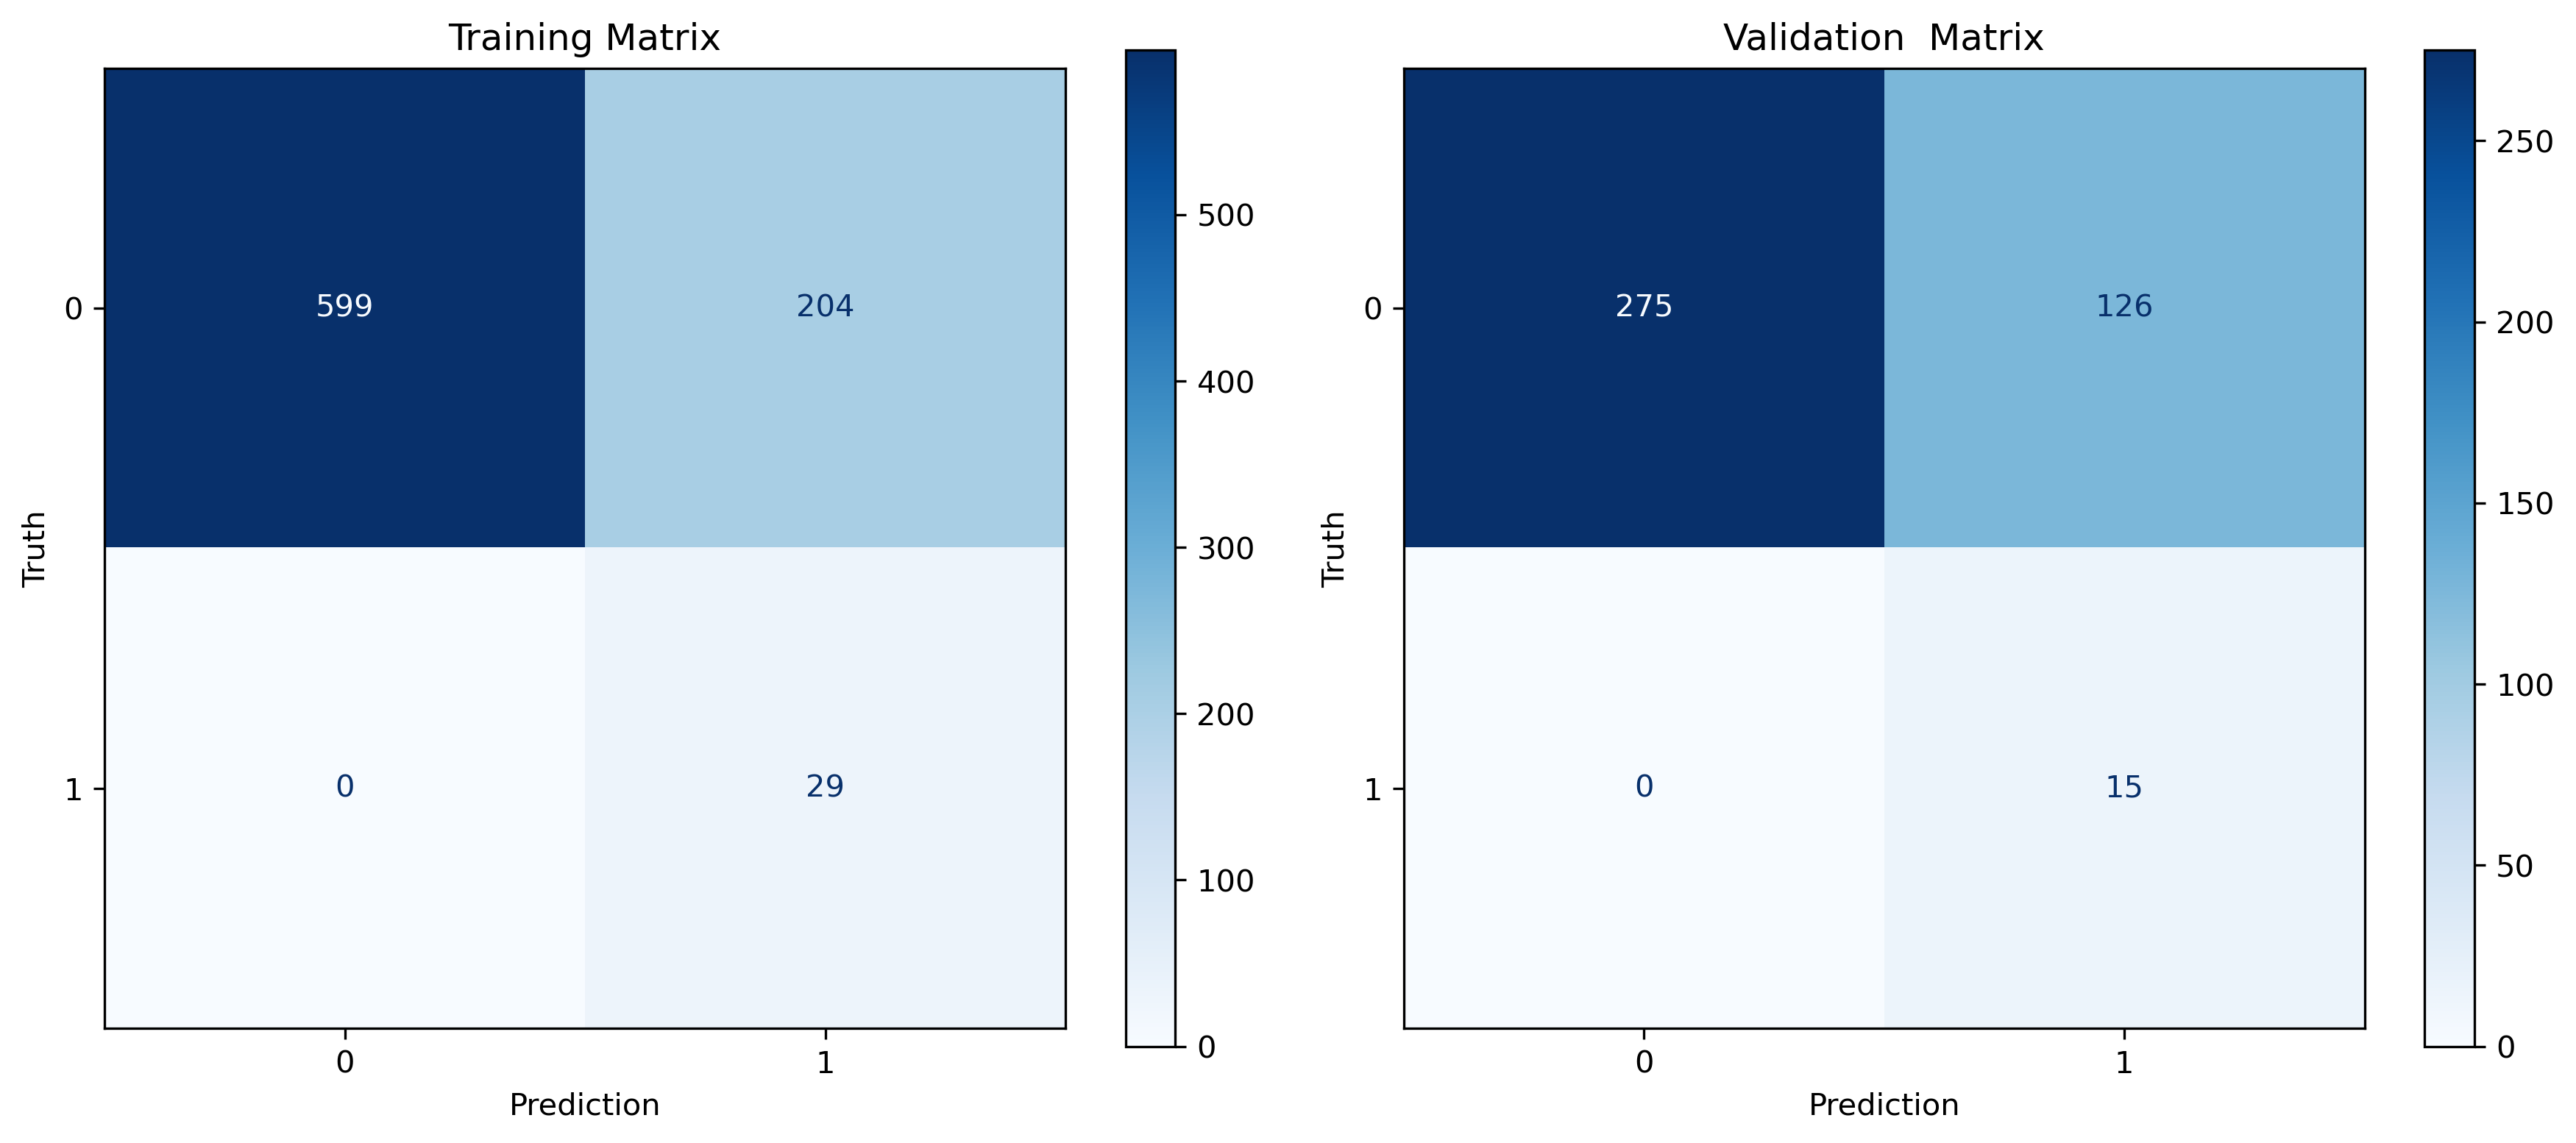

In [5]:
from eppi_text_classification.plots import binary_train_valid_confusion_plot

binary_train_valid_confusion_plot(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
)

In [8]:
import plotly.graph_objects as go

fig = go.Figure(
    data=go.Heatmap(
        z=cm,
        x=labels,
        y=labels,
        colorscale="Blues",
        showscale=True,  # Shows the color bar
    )
)


def get_font_color(value, cm):
    if value > cm.max() / 2:
        return "white"
    else:
        return " dark blue"


# Adding text annotations manually
annotations = []
for i, row in enumerate(cm):
    for j, value in enumerate(row):
        annotations.append(
            go.layout.Annotation(
                text=str(value),
                x=labels[j],
                y=labels[i],
                xref="x1",
                yref="y1",
                font=dict(color=get_font_color(value, cm)),
                showarrow=False,
            )
        )

fig.update_layout(
    annotations=annotations,
    autosize=False,
    width=500,
    height=500,
    title_text="Confusion Matrix",
    title_x=0.5,  # Centers the title
    xaxis=dict(title="Predicted Value", side="bottom"),
    yaxis=dict(title="True Value", side="left"),
)


fig.add_shape(
    type="rect",
    xref="x",  # Change to data reference for x-axis
    yref="y",  # Change to data reference for y-axis
    x0=-0.5,  # Start at first x-axis category index
    y0=-0.5,  # Start at first y-axis category index
    x1=len(labels) - 0.5,  # End at last x-axis category index
    y1=len(labels) - 0.5,  # End at last y-axis category index
    line=dict(color="black", width=2),
)

fig.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=-0.5,
    y0=0.5,
    x1=len(labels) - 0.5,
    y1=0.5,
    line=dict(color="black", width=1.5),
)

fig.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=0.5,
    y0=-0.5,
    x1=0.5,
    y1=1.5,
    line=dict(color="black", width=1.5),
)


fig.show()

In [10]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import confusion_matrix

labels = ["0", "1"]
cm = confusion_matrix(y_train, y_train_pred)
cm = np.array([[cm[0, 1], cm[0, 0]], [cm[1, 1], cm[1, 0]]])

fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=["Training Matrix", "Validation Matrix"],
)

# Increase font size and height of titles
for annotation in fig["layout"]["annotations"]:
    annotation["font"] = dict(size=18)  # Increase font size here
    annotation["y"] = 1.03  # Increase height of title


fig.update_layout(
    autosize=False,
    width=700,
    height=400,
)
# Adding heatmaps to both subplots
for index in [1, 2]:
    fig.add_trace(
        go.Heatmap(z=cm, x=labels[::-1], y=labels, colorscale="Blues", showscale=True),
        row=1,
        col=index,
    )


def get_font_color(value, cm):
    if value > cm.max() / 2:
        return "white"
    else:
        return " dark blue"


# Adding annotations and shapes
for index in [1, 2]:
    # annotations = []
    for i, row in enumerate(cm):
        for j, value in enumerate(row):
            fig.add_annotation(
                dict(
                    text=str(value),
                    x=labels[j],
                    y=labels[i],
                    xref=f"x{index}",
                    yref=f"y{index}",
                    showarrow=False,
                    font=dict(color=get_font_color(value, cm)),
                )
            )

    # Add rectangle and line shapes per subplot
    fig.add_shape(
        type="rect",
        xref=f"x{index}",
        yref=f"y{index}",
        x0=-0.5,
        y0=-0.5,
        x1=len(labels) - 0.5,
        y1=len(labels) - 0.5,
        line=dict(color="black", width=2),
    )
    fig.add_shape(
        type="line",
        xref=f"x{index}",
        yref=f"y{index}",
        x0=-0.5,
        y0=0.5,
        x1=len(labels) - 0.5,
        y1=0.5,
        line=dict(color="black", width=1.5),
    )
    fig.add_shape(
        type="line",
        xref=f"x{index}",
        yref=f"y{index}",
        x0=0.5,
        y0=-0.5,
        x1=0.5,
        y1=1.5,
        line=dict(color="black", width=1.5),
    )


for i in range(1, 3):
    fig.update_xaxes(
        title_text="Predicted",
        row=1,
        col=i,
        tickmode="array",
        tickvals=[0, 1],
        ticktext=labels[::-1],
        ticks="outside",
        ticklen=5,  # Shorten tick length to touch grid lines
        tickwidth=1,
        tickcolor="black",
        mirror=True,  # Mirror ticks on both sides
    )
    fig.update_yaxes(
        title_text="True",
        row=1,
        col=i,
        tickmode="array",
        tickvals=[0, 1],
        ticktext=labels,
        ticks="outside",
        ticklen=5,  # Shorten tick length to touch grid lines
        tickwidth=1,
        tickcolor="black",
        mirror=True,  # Mirror ticks on both sides
        title_standoff=0.3,
    )

# Update layout for a better view

fig.show()

In [33]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import confusion_matrix

labels = ["0", "1"]
cm = confusion_matrix(y_train, y_train_pred)
cm = np.array([[cm[0, 1], cm[0, 0]], [cm[1, 1], cm[1, 0]]])

fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=("Confusion Matrix 1", "Confusion Matrix 2", "Confusion Matrix 3"),
)

fig.update_layout(
    autosize=False,
    width=1000,
    height=400,
)
# Adding heatmaps to both subplots
for index in [1, 2, 3]:
    fig.add_trace(
        go.Heatmap(z=cm, x=labels[::-1], y=labels, colorscale="Blues", showscale=True),
        row=1,
        col=index,
    )


def get_font_color(value, cm):
    if value > cm.max() / 2:
        return "white"
    else:
        return " dark blue"


# Adding annotations and shapes
for index in [1, 2, 3]:
    for i, row in enumerate(cm):
        for j, value in enumerate(row):
            fig.add_annotation(
                dict(
                    text=str(value),
                    x=labels[j],
                    y=labels[i],
                    xref=f"x{index}",
                    yref=f"y{index}",
                    showarrow=False,
                    font=dict(color=get_font_color(value, cm)),
                )
            )

    # Add rectangle and line shapes per subplot
    fig.add_shape(
        type="rect",
        xref=f"x{index}",
        yref=f"y{index}",
        x0=-0.5,
        y0=-0.5,
        x1=len(labels) - 0.5,
        y1=len(labels) - 0.5,
        line=dict(color="black", width=2),
    )
    fig.add_shape(
        type="line",
        xref=f"x{index}",
        yref=f"y{index}",
        x0=-0.5,
        y0=0.5,
        x1=len(labels) - 0.5,
        y1=0.5,
        line=dict(color="black", width=1.5),
    )
    fig.add_shape(
        type="line",
        xref=f"x{index}",
        yref=f"y{index}",
        x0=0.5,
        y0=-0.5,
        x1=0.5,
        y1=1.5,
        line=dict(color="black", width=1.5),
    )

# Update layout for a better view

fig.show()

layout.Annotation({
    'font': {'size': 16},
    'showarrow': False,
    'text': 'Confusion Matrix 1',
    'x': 0.14444444444444446,
    'xanchor': 'center',
    'xref': 'paper',
    'y': 1.0,
    'yanchor': 'bottom',
    'yref': 'paper'
})
layout.Annotation({
    'font': {'size': 16},
    'showarrow': False,
    'text': 'Confusion Matrix 2',
    'x': 0.5,
    'xanchor': 'center',
    'xref': 'paper',
    'y': 1.0,
    'yanchor': 'bottom',
    'yref': 'paper'
})


In [31]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import confusion_matrix

import plotly.io as pio

labels = ["0", "1"]
cm = confusion_matrix(y_train, y_train_pred)
cm = np.array([[cm[0, 1], cm[0, 0]], [cm[1, 1], cm[1, 0]]])

cm2 = confusion_matrix(y_test, y_test_pred)
cm2 = np.array([[cm2[0, 1], cm2[0, 0]], [cm2[1, 1], cm2[1, 0]]])

fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=["Training Matrix", "Validation Matrix"],
    horizontal_spacing=0.15,
)

# Increase font size and height of titles
for annotation in fig["layout"]["annotations"]:
    annotation["font"] = dict(size=18)  # Increase font size here
    annotation["y"] = 1.03  # Increase height of title


fig.update_layout(
    autosize=False,
    width=700,
    height=400,
)


hover_text = np.empty_like(cm, dtype=object)
hover_text[0, 0] = f"Truth: Excluded<br>Prediction: Included<br>Total: {cm[0,0]}"
hover_text[0, 1] = f"Truth: Excluded<br>Prediction: Excluded<br>Total: {cm[0,1]}"
hover_text[1, 0] = f"Truth: Included<br>Prediction: Included<br>Total: {cm[1,0]}"
hover_text[1, 1] = f"Truth: Included<br>Prediction: Excluded<br>Total: {cm[1,1]}"


# Adding heatmaps to both subplots

fig.add_trace(
    go.Heatmap(
        z=cm,
        x=labels,
        y=labels,
        colorscale="Blues",
        showscale=False,
        text=hover_text,
        hoverinfo="text",
    ),
    row=1,
    col=1,
)

hover_text = np.empty_like(cm2, dtype=object)
hover_text[0, 0] = f"Truth: Excluded<br>Prediction: Included<br>Total: {cm2[0,0]}"
hover_text[0, 1] = f"Truth: Excluded<br>Prediction: Excluded<br>Total: {cm2[0,1]}"
hover_text[1, 0] = f"Truth: Included<br>Prediction: Included<br>Total: {cm2[1,0]}"
hover_text[1, 1] = f"Truth: Included<br>Prediction: Excluded<br>Total: {cm2[1,1]}"

fig.add_trace(
    go.Heatmap(
        z=cm2,
        x=labels,
        y=labels,
        colorscale="Blues",
        showscale=False,
        text=hover_text,
        hoverinfo="text",
    ),
    row=1,
    col=2,
)


def get_font_color(value, cm):
    if value > cm.max() / 2:
        return "white"
    else:
        return " dark blue"


for i, row in enumerate(cm):
    for j, value in enumerate(row):
        fig.add_annotation(
            dict(
                text=str(value),
                x=labels[j],
                y=labels[i],
                xref=f"x{1}",
                yref=f"y{1}",
                showarrow=False,
                font=dict(color=get_font_color(value, cm)),
            )
        )

for i, row in enumerate(cm2):
    for j, value in enumerate(row):
        fig.add_annotation(
            dict(
                text=str(value),
                x=labels[j],
                y=labels[i],
                xref=f"x{index}",
                yref=f"y{index}",
                showarrow=False,
                font=dict(color=get_font_color(value, cm2)),
            )
        )

# Adding annotations and shapes
for index in [1, 2]:
    # Add rectangle and line shapes per subplot
    fig.add_shape(
        type="rect",
        xref=f"x{index}",
        yref=f"y{index}",
        x0=-0.5,
        y0=-0.5,
        x1=len(labels) - 0.5,
        y1=len(labels) - 0.5,
        line=dict(color="black", width=2),
    )
    fig.add_shape(
        type="line",
        xref=f"x{index}",
        yref=f"y{index}",
        x0=-0.5,
        y0=0.5,
        x1=len(labels) - 0.5,
        y1=0.5,
        line=dict(color="black", width=1.5),
    )
    fig.add_shape(
        type="line",
        xref=f"x{index}",
        yref=f"y{index}",
        x0=0.5,
        y0=-0.5,
        x1=0.5,
        y1=1.5,
        line=dict(color="black", width=1.5),
    )


for i in range(1, 3):
    fig.update_xaxes(
        title_text="Prediction",
        row=1,
        col=i,
        tickmode="array",
        tickvals=[0, 1],
        ticktext=labels[::-1],
        ticks="outside",
        ticklen=5,  # Shorten tick length to touch grid lines
        tickwidth=1,
        tickcolor="black",
        mirror=True,  # Mirror ticks on both sides
    )
    fig.update_yaxes(
        title_text="Truth",
        row=1,
        col=i,
        tickmode="array",
        tickvals=[0, 1],
        ticktext=labels,
        ticks="outside",
        ticklen=5,  # Shorten tick length to touch grid lines
        tickwidth=1,
        tickcolor="black",
        mirror=True,  # Mirror ticks on both sides
        title_standoff=0.3,
    )

# Update layout for a better view
pio.write_html(
    fig,
    file="confusion_matrix.html",
    auto_open=True,
    include_plotlyjs="cdn",
)

fig.show()